In [2]:
#########################################################################################
#                                0 - GLOBAL VARIABLE SETUP
#########################################################################################

import pandas as pd
import numpy as np
import matplotlib.ticker as ticker 
import matplotlib.pyplot as plt
from scipy.integrate import simps
import spm1d
import os
import matplotlib.gridspec as gridspec

Titles=['Raw Curves','Mean & StdDevs','SPM Analysis']

Colours =[['royalblue','m','r','g','darkorange'],
          ['lightsteelblue','violet','salmon','lightgreen','moccasin']]

E = [['E1','E2','E3','E4','E5','E6','E7'],
     ['Element 1','Element 2','Element 3','Element 4','Element 5','Element 6','Element 7']]
J = [['J1','J2','J3','J4','J5','J6','J7'],
     ['Elbow','Shoulder Abd/Add', 'Shoulder For/Back','Trunk Flex/Ext','Trunk Lat','Hip Flex/Ext', 'Knee Flex/Ext']]
G = [['G1A','G2A','G3A','G4A'], 
     ['Group 1','Group 2','Group 3','Group 4']]


BarChart_Dict={}
Element=E[0][0]

## Element_X - Joint_X

C:\Users\KAGUMBA\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: 



Text(0.5, 0.98, 'E1 - Elbow')

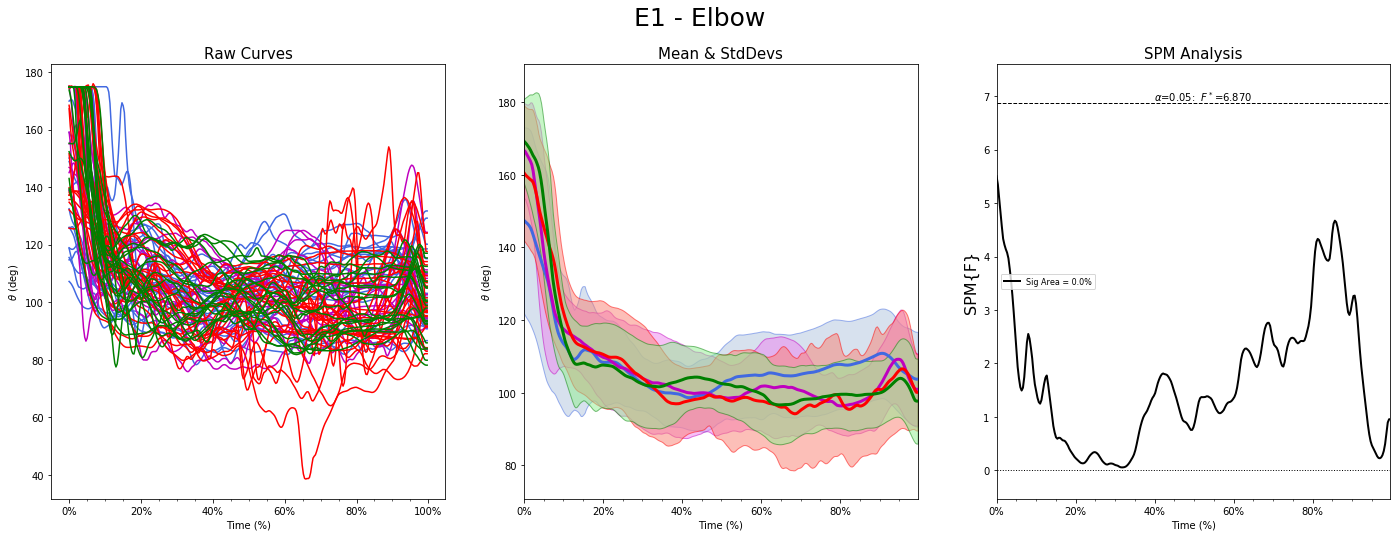

In [10]:
#Initialize local variables each time a joint cell is called
Joint = J[0][0]
BarChart_Dict[Joint]={}
Col=[]
MaxIndex=0
#########################################################################################
#                                   1 - DATA SETUP
#########################################################################################
for Group in G[0]:
    for entry in os.scandir(r'F:\Final_Curves'):
        filename='{}_{}_{}_JA'.format(Element,Group,Joint)   
        #All data is setup in the form (E?_G?A_J?_JA) 
        if filename in entry.path:
            
            Raw_Data = pd.read_csv(entry.path, sep='\t')

            #Re-arrange raw data to operate on
            Sample_Set = Raw_Data[Raw_Data.columns[1::2]].reindex(sorted(Raw_Data.columns[1::2]), axis=1)
            
            if len(Sample_Set.index) > MaxIndex:
                MaxIndex = len(Sample_Set.index)
            
            for i in Sample_Set.columns:
                Col.append(i)

   
Y = pd.DataFrame(columns=Col, index=[i for i in range(MaxIndex)])
A = []

for Index, Group in enumerate(G[0]):
    for entry in os.scandir(r'F:\Final_Curves'):
        filename='{}_{}_{}_JA'.format(Element,Group,Joint)
        if filename in entry.path:
            
            Raw_Data = pd.read_csv(entry.path, sep='\t')

            #Re-arrange raw data to operate on
            Sample_Set = Raw_Data[Raw_Data.columns[1::2]].reindex(sorted(Raw_Data.columns[1::2]), axis=1)
            
            for i in Sample_Set.columns:
                Y[i]=spm1d.util.interp(Sample_Set[i], Q=MaxIndex)
                A.append(Index)
                
Y.columns=A

Y=Y.T.to_numpy()
A=np.array(A)
#########################################################################################
#                                       2 - COMPUTE ANOVA
#########################################################################################
alpha        = 0.05
F            = spm1d.stats.anova1(Y, A, equal_var=False)
Fi           = F.inference(alpha)

Fi_arr=[]

for i in Fi.z:
    if i >= Fi.zstar:
        Fi_arr.append(i)
    else:
        Fi_arr.append(Fi.zstar)

Fi_Sig_Area = (simps(np.array(Fi_arr)-Fi.zstar, dx=1)/simps(Fi.z, dx=1))*100            
#########################################################################################
#                                       3 - PLOT DATA
#########################################################################################

fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(24, 8))



############################### ax0 - Raw curves ######################## 
ax0.set_title('{}'.format(Titles[0]),fontsize=15)
ax0.set_xlabel('Time (%)', fontsize=10)
ax0.set_ylabel(r'$\theta$ (deg)', fontsize=10)


for k in set(A):
    ax0.plot(Y[A==k].T, Colours[0][k])

ax0.xaxis.set_major_locator(ticker.MultipleLocator(MaxIndex/5))
ax0.xaxis.set_minor_locator(ticker.MultipleLocator(MaxIndex/20))
ax0.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=MaxIndex))
    
############################### ax1 - Mean and StdDev ########################  
ax1.set_title('{}'.format(Titles[1]),fontsize=15)    
ax1.set_xlabel('Time (%)', fontsize=10)
ax1.set_ylabel(r'$\theta$ (deg)', fontsize=10)
    
for k in set(A):
    spm1d.plot.plot_mean_sd(Y[A==k], ax=ax1, facecolor=Colours[1][k], 
                            linecolor=Colours[0][k], edgecolor=Colours[0][k])
    
ax1.xaxis.set_major_locator(ticker.MultipleLocator(MaxIndex/5))
ax1.xaxis.set_minor_locator(ticker.MultipleLocator(MaxIndex/20))
ax1.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=MaxIndex))
    
############################### ax2 - SMP1D ########################  
ax2.set_title('{}'.format(Titles[2]),fontsize=15)    
ax2.set_xlabel('Time (%)', fontsize=10)
ax2.set_ylabel('SPM {F}', fontsize=10)

Fi.plot(ax=ax2, color='k', label='Sig Area = {0:.1f}%'.format(Fi_Sig_Area))
Fi.plot_threshold_label(ax=ax2,color='k',ha='left')
ax2.legend(fontsize=8, loc='center left')

ax2.xaxis.set_major_locator(ticker.MultipleLocator(MaxIndex/5))
ax2.xaxis.set_minor_locator(ticker.MultipleLocator(MaxIndex/20))
ax2.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=MaxIndex))

BarChart_Dict[Joint]=Fi_Sig_Area

fig.suptitle('{} - {}'.format(Element,J[1][0]), y=0.98, fontsize=25) 

In [9]:
#Display a dict that has a summary of each joint's statistics
BarChart_Dict

{'J1': 0.0,
 'J2': 69.25882698005027,
 'J3': 1.3045815616537262,
 'J4': 0.0,
 'J5': 8.190924957273825,
 'J6': 2.5790382764750537,
 'J7': 37.740152739909355}